In [1]:
import pandas as pd

In [2]:
clinical = pd.read_csv('data/clinical.tsv', sep='\t', index_col='ID')

genecount = pd.read_csv('data/gene_count.tsv', sep='\t', index_col='ID')

clinical_gene = clinical.join(genecount, how='inner')

clinical_gene.shape

(749, 27833)

In [3]:
from collections import Counter
Counter(clinical_gene['therapy_first_line_class'].fillna(''))

Counter({'': 39,
         'Combined bortezomib/IMIDs-based': 351,
         'Bortezomib-based': 146,
         'IMIDs-based': 39,
         'Combined bortezomib/IMIDs/carfilzomib-based': 20,
         'Combined IMIDs/carfilzomib-based': 113,
         'Carfilzomib-based': 40,
         'Combined bortezomib/carfilzomib-based': 1})

In [4]:
Counter(clinical_gene['response_best_response_first_line'].fillna(''))

Counter({0.0: 553, 1.0: 171, '': 25})

In [5]:
Counter(clinical_gene['response_days_to_disease_progression'].fillna(''))

Counter({0.0: 196, 1.0: 177, '': 376})

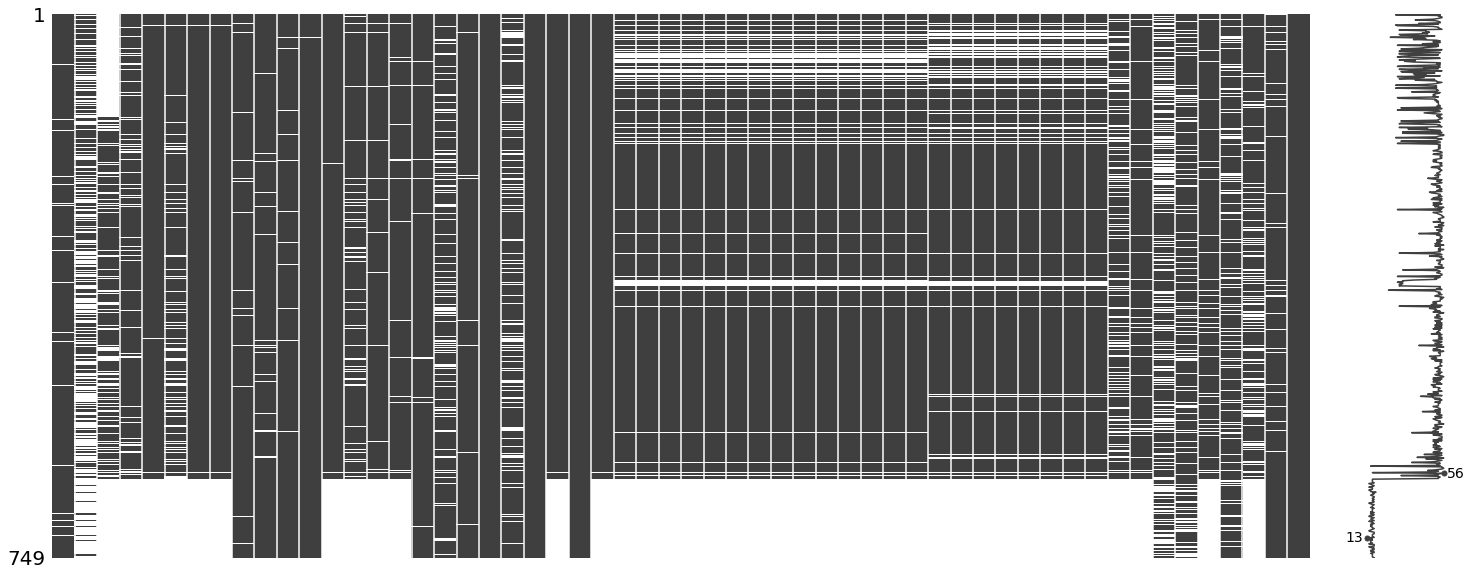

In [6]:
%matplotlib inline

import missingno as msn

msn.matrix(clinical_gene.iloc[:,:clinical.shape[1]]);

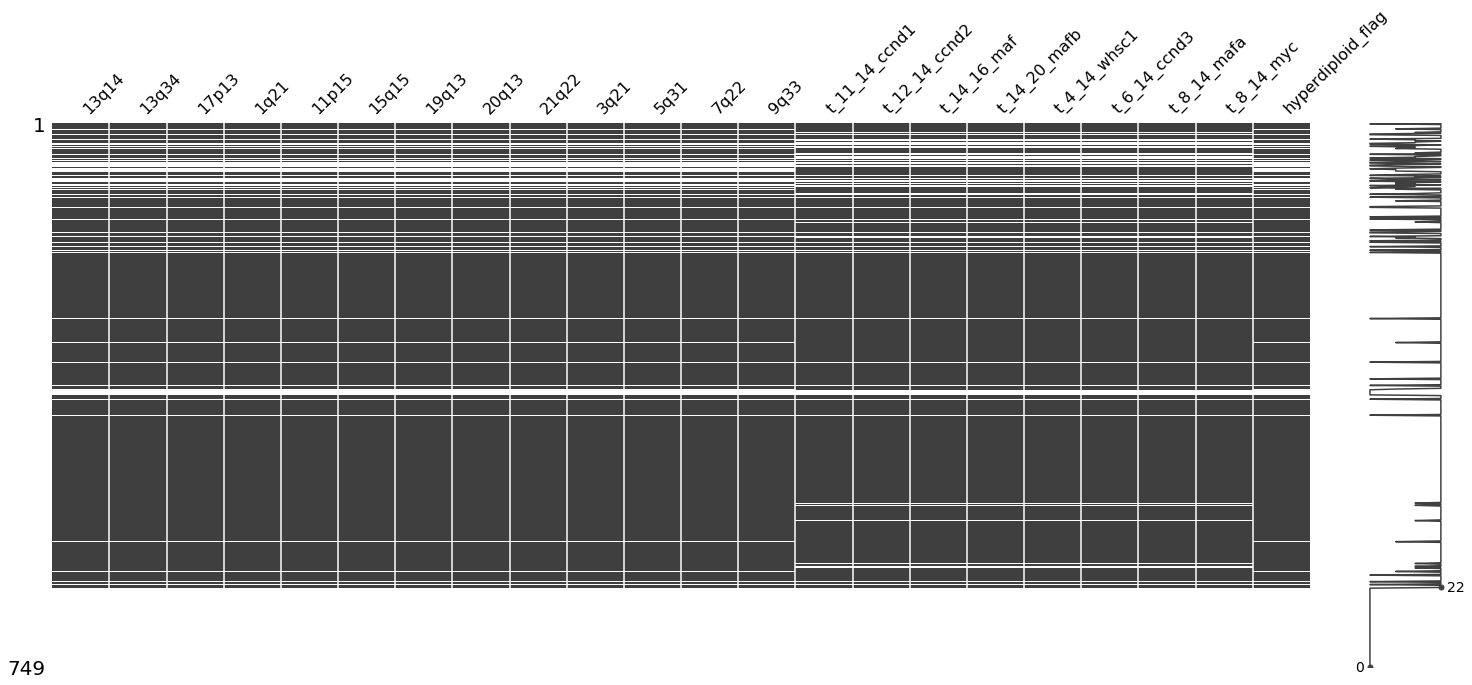

In [7]:
import numpy as np

translocations = [
    '13q14', '13q34', '17p13', '1q21', '11p15', '15q15', '19q13', '20q13', '21q22', '3q21',
    '5q31', '7q22', '9q33', 't_11_14_ccnd1', 't_12_14_ccnd2', 't_14_16_maf', 't_14_20_mafb',
    't_4_14_whsc1',  't_6_14_ccnd3', 't_8_14_mafa', 't_8_14_myc', 'hyperdiploid_flag'
]

for t in translocations:
    clinical_gene[t] = clinical_gene[t].apply(lambda x: {'Detected': 1, 'Not Detected': 0}.get(x, np.nan))

msn.matrix(clinical_gene[translocations]);

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

space = [
    Real(1e-6, 9e-1, 'log-uniform', name='learning_rate'),
    Integer(7, 4095, name='num_leaves'),
    Integer(2, 100, name='max_depth'),
    Integer(1, 4000, name='scale_pos_weight'),
    Real(0.01, 1.5, name='min_child_weight'),
    Real(0.4, .9, name='colsample_bytree'),
    Real(0.001, 100, 'log-uniform', name='min_split_gain'),
    Integer(1, 50, name='min_child_samples'),
    Real(0.4, 0.9, name='subsample')]

def optimize(x, y, space, n_calls=50):
    
    @use_named_args(space)
    def objective(num_leaves, max_depth, scale_pos_weight, min_child_weight, colsample_bytree, learning_rate,
                  min_split_gain, min_child_samples, subsample):

        scores = []
        
        kf = StratifiedKFold(2, shuffle=True, random_state=185) 

        params = {
            'learning_rate': learning_rate,
            'num_leaves': int(num_leaves),
            'max_depth': int(max_depth),
            'scale_pos_weight': int(scale_pos_weight),
            'min_child_weight': min_child_weight,
            'colsample_bytree': colsample_bytree,
            'min_split_gain': min_split_gain,
            'min_child_samples': int(min_child_samples),
            'subsample': subsample,
  
            'subsample_for_bin': 2,
            'objective':'binary',
            'metric':'auc',
            'eval_metric':'auc',
            'is_unbalance':False,
            'nthread':24,          
            'verbose': -1}
        
        for train_index, valid_index in kf.split(x, y):
            
            lgb_train = lgb.Dataset(x[train_index,:], y[train_index, 0])
            lgb_valid = lgb.Dataset(x[valid_index,:], y[valid_index, 0])
            
            gbm = lgb.train(params, lgb_train, num_boost_round=1000,  
                            valid_sets=lgb_valid, early_stopping_rounds=100, verbose_eval=False) 

            y_hat = gbm.predict(x[valid_index,:], num_iteration=gbm.best_iteration, verbose_eval=False)

            auc = roc_auc_score(y[valid_index,0], y_hat)
            
            scores.append(auc)
            
        return -(np.mean(scores))
    
    return gp_minimize(objective, space, n_calls=n_calls, random_state=22, verbose=False, n_jobs=-1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
from correlation import select_genes
from evaluation import optimize_threshold

import lightgbm as lgb
import pickle
import os

fill = {}

for t in translocations:
    
    try:
        
        translocation = clinical_gene[t]

        translocation_fill = translocation[~translocation.isnull()]
        translocation_unfill = translocation[translocation.isnull()]

        train = pd.DataFrame(translocation_fill).join(genecount, how='inner')
        valid = pd.DataFrame(translocation_unfill).join(genecount, how='inner')

        x_train, y_train = train.iloc[:,1:], train.iloc[:,[0]]
        x_valid, y_valid = valid.iloc[:,1:], valid.iloc[:,[0]]

        #
        #
        #
        file_name = 'output/fill/selected_genes_{}.pkl'.format(t)

        if os.path.exists(file_name):
            with open(file_name, 'rb') as file:
                selected_genes = pickle.load(file)

        else:

            selected_genes = sorted(list(select_genes(x_train, y_train.values[:,0], threshold=0.05)))
            
            selected_genes = selected_genes[:min(1500, len(selected_genes))]

            with open(file_name, 'wb') as file:
                pickle.dump(selected_genes, file)

        print('{} selected genes for translocation {}'.format(len(selected_genes), t))

        x_train = x_train[selected_genes]
        x_valid = x_valid[selected_genes]

        file_name = 'output/fill/{}.lgbm'.format(t)

        if os.path.exists(file_name):
            gbm = lgb.Booster(model_file=file_name)

        else:
            #
            # Optimization
            #
            opt = optimize(x_train.values, y_train.values, space, n_calls=10).x

            #
            # LightGBM
            #    
            print('Training')

            params = {
                'learning_rate': opt[0],
                'num_leaves': opt[1],
                'max_depth': opt[2],
                'scale_pos_weight': opt[3],
                'min_child_weight': opt[4],
                'colsample_bytree': opt[5],
                'min_split_gain': opt[6],
                'min_child_samples': opt[7],
                'subsample': opt[8],

                'subsample_for_bin': 2,
                'objective':'binary',
                'metric':'auc',
                'eval_metric':'auc',
                'is_unbalance':False,
                'nthread':24,          
                'verbose': -1}

            opt_kf = StratifiedKFold(5, shuffle=True, random_state=185) 

            for opt_train, opt_valid in opt_kf.split(x_train, y_train):

                lgb_train = lgb.Dataset(x_train.values[opt_train,:], list(y_train.values[opt_train,:].reshape((-1,))))
                lgb_valid = lgb.Dataset(x_train.values[opt_valid,:], list(y_train.values[opt_valid,:].reshape((-1,))))

                gbm = lgb.train(params, lgb_train, valid_sets=lgb_valid, num_boost_round=1000, early_stopping_rounds=100, verbose_eval=False)    

                break
            #
            #
            #
            gbm.save_model('output/fill/{}.lgbm'.format(t), num_iteration=gbm.best_iteration) 

        y_limit = optimize_threshold(y_train, gbm.predict(x_train), 0.0001)

        clinical_gene.loc[translocation_unfill.index, t] = [int(v >= y_limit) for v in gbm.predict(x_valid)]
    
    except:
        
        print('Some error with translocation {}'.format(t))

Some error with translocation 13q14
Some error with translocation 13q34
Some error with translocation 17p13
Some error with translocation 1q21
Some error with translocation 11p15
Some error with translocation 15q15
Some error with translocation 19q13
Some error with translocation 20q13
Some error with translocation 21q22
Some error with translocation 3q21
Some error with translocation 5q31
Some error with translocation 7q22
Some error with translocation 9q33
Some error with translocation t_11_14_ccnd1
Some error with translocation t_12_14_ccnd2
Some error with translocation t_14_16_maf
Some error with translocation t_14_20_mafb
Some error with translocation t_4_14_whsc1
Some error with translocation t_6_14_ccnd3
Some error with translocation t_8_14_mafa
Some error with translocation t_8_14_myc
Some error with translocation hyperdiploid_flag


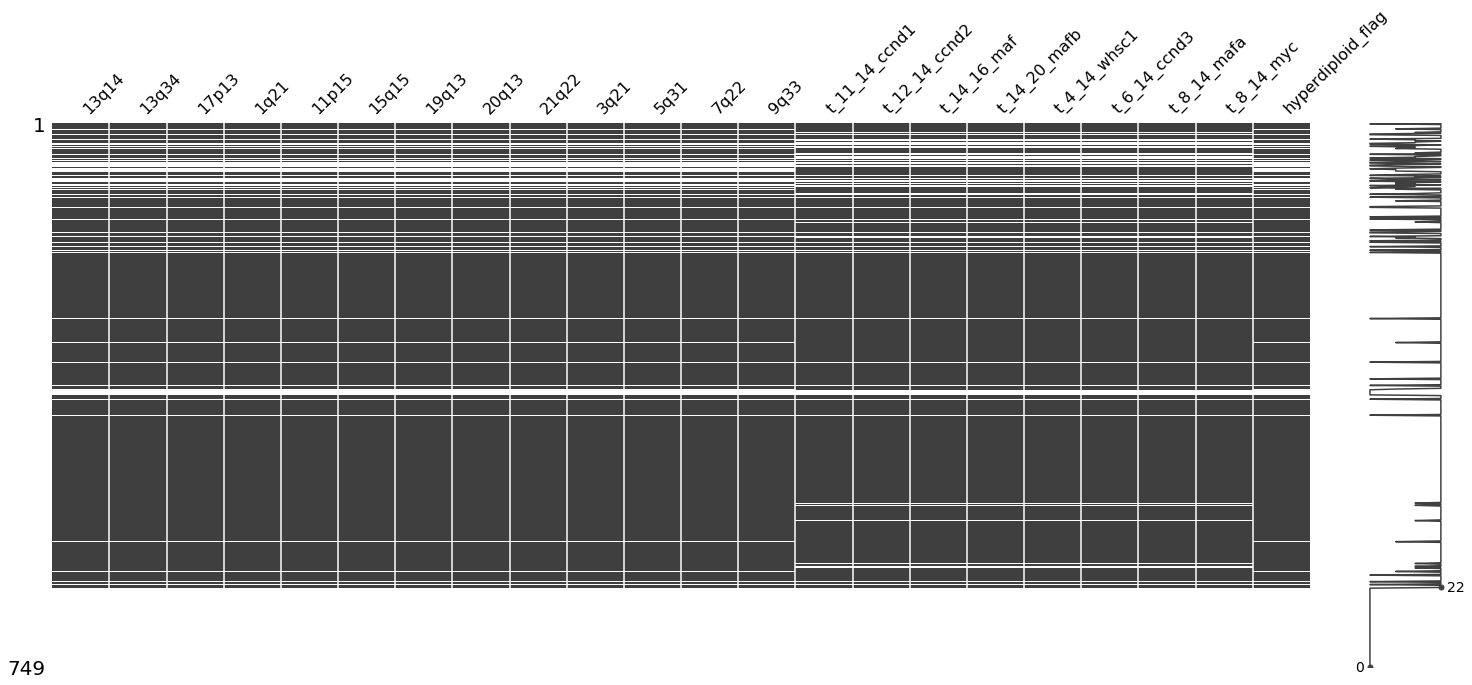

In [10]:
msn.matrix(clinical_gene[translocations]);

In [11]:
clinical_description = {'variable': [], 'type': [], 'number of values': [], 'sample':[], 'nas': [], 'count': []}

for c in clinical.columns:
    
    if c in translocations:
        continue
        
    clinical_description['variable'].append(c)
    
    clinical_description['type'].append(str(clinical_gene[c].dtype))
    
    nvalues = len(clinical_gene[c].unique())
    
    clinical_description['number of values'].append(nvalues)
    
    clinical_description['nas'].append(clinical_gene[c].isnull().sum())
    
    clinical_description['count'].append((~clinical_gene[c].isnull()).sum())
    
    try:
        clinical_description['sample'].append(', '.join([str(v) for v in clinical_gene[c].unique()[:min(5, nvalues)]]))
        
    except:
        clinical_description['sample'].append(None)

clinical_description = pd.DataFrame(clinical_description)

clinical_description

,variable,type,number of values,sample,nas,count
0,response_best_response_first_line,float64,3,"0.0, 1.0, nan",25,724
1,response_days_to_disease_progression,float64,3,"0.0, 1.0, nan",376,373
2,cmmc,float64,361,"nan, 5913.0, 22169.0, 3864.0, 12438.0",363,386
3,ecog_ps,object,6,PS 1 (Restricted in physically strenuous activ...,177,572
4,cell_markers,object,5,"CD13, CD117, CD138, nan, CD38",114,635
5,percent_aneuploid,float64,250,"0.0, 11.0, 15.4, 18.3, 20.7",193,556
6,percent_plama_cells_bone_marrow,float64,347,"4.9, 6.0, 8.4, 9.6, 10.1",112,637
7,percent_plama_cells_peripherical_blood,float64,84,"0.0, 0.1, 0.6, 0.03, nan",112,637
8,creatinine,float64,262,"88.4, 123.76, 106.08, 55.692, 81.328",15,734
9,iss,float64,4,"1.0, 2.0, 3.0, nan",20,729


In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import LabelEncoder

space  = [
    Real(1e-6, 9e-1, 'log-uniform', name='learning_rate'),
    Integer(7, 4095, name='num_leaves'),
    Integer(2, 100, name='max_depth'),
    Integer(1, 4000, name='scale_pos_weight'),
    Real(0.01, 1.5, name='min_child_weight'),
    Real(0.4, .9, name='colsample_bytree'),
    Real(0.001, 100, 'log-uniform', name='min_split_gain'),
    Integer(1, 50, name='min_child_samples'),
    Real(0.4, 0.9, name='subsample')]

def optimize_multiclass_regression(x, y, space, objective_string, metric, n_calls=50):
    
    if objective_string == 'multiclass':
        y = LabelEncoder().fit_transform(y[:,0])
    
    @use_named_args(space)
    def objective(num_leaves, max_depth, scale_pos_weight, min_child_weight, colsample_bytree, learning_rate,
                  min_split_gain, min_child_samples, subsample):
        
        scores = []

        params = {
            'learning_rate': learning_rate,
            'num_leaves': int(num_leaves),
            'max_depth': int(max_depth),
            'scale_pos_weight': int(scale_pos_weight),
            'min_child_weight': min_child_weight,
            'colsample_bytree': colsample_bytree,
            'min_split_gain': min_split_gain,
            'min_child_samples': int(min_child_samples),
            'subsample': subsample,
  
            'subsample_for_bin': 2,
            'objective':objective_string,
            'metric': metric,
            'eval_metric': metric,
            'is_unbalance':False,
            'nthread':24,          
            'verbose': -1}
        
        if objective_string == 'multiclass':
            
            params['num_class'] = len(np.unique(y))
            
            kf = StratifiedKFold(5, shuffle=True, random_state=185) 
            
        else:
            
            kf = KFold(5, shuffle=True, random_state=185) 
        
        for train_index, valid_index in kf.split(x, y):
            
            lgb_train = lgb.Dataset(x[train_index,:], y[train_index])
            
            lgb_valid = lgb.Dataset(x[valid_index,:], y[valid_index])
            
            gbm = lgb.train(params, lgb_train, num_boost_round=1000,  
                            valid_sets=lgb_valid, early_stopping_rounds=100, verbose_eval=False) 
            
            y_hat = gbm.predict(x[valid_index,:], num_iteration=gbm.best_iteration, verbose_eval=False)
            
            if objective_string == 'multiclass':
                scores.append(log_loss(y[valid_index], y_hat))
            
            else:
                scores.append(np.sqrt(mean_squared_error(y[valid_index, 0], y_hat)))
        
        return np.mean(scores)
    
    return gp_minimize(objective, space, n_calls=n_calls, random_state=22, verbose=False, n_jobs=-1)

In [13]:
from correlation import select_genes, select_genes_mic
from sklearn.model_selection import KFold
import sys, os, pickle, lightgbm as lgb

for index, row in clinical_description.iterrows():
    
    if row['nas'] < 10 or row['variable'] in {'response_best_response_first_line', 'response_days_to_disease_progression'}:
        continue
    
    t = row['variable']
    
    objective = 'multiclass' if row['type'] == 'object' or row['variable'] == 'iss' else 'regression'
    
    metric = 'multi_logloss' if row['type'] == 'object' or row['variable'] == 'iss' else 'root_mean_squared_error'
    
    print('Filling variable {} ({}, {}, {})'.format(t, row['type'], objective, metric))
    
    try:
        
        translocation = clinical_gene[t]

        translocation_fill = translocation[~translocation.isnull()]
        translocation_unfill = translocation[translocation.isnull()]

        train = pd.DataFrame(translocation_fill).join(genecount.iloc[:,:50], how='inner')
        valid = pd.DataFrame(translocation_unfill).join(genecount.iloc[:,:50], how='inner')

        x_train, y_train = train.iloc[:,1:], train.iloc[:,[0]]
        x_valid, y_valid = valid.iloc[:,1:], valid.iloc[:,[0]]
        
        if x_valid.shape[0] == 0:
            print('Empty values\n')
            continue
        
        #
        #
        #
        file_name = 'output/fill/1_selected_genes_{}.pkl'.format(t)

        if os.path.exists(file_name):
            with open(file_name, 'rb') as file:
                selected_genes = pickle.load(file)

        else:
            
            print('feature selection', end= ' ')
            
            if row['type'] == 'object':
                
                print('with differential expression')
                
                dummies = pd.get_dummies(y_train)
                
                selected_genes = []
                
                for c in dummies.columns:
                    selected_genes += select_genes(x_train, dummies[c].values, threshold=0.05)
                    
                selected_genes = list(set(selected_genes))    
                    
            else:
                
                print('with MIC')
                
                selected_genes = list(x_train.columns[:50])#list(select_genes_mic(x_train, y_train.values[:,0], threshold=0.05))
            
            selected_genes = selected_genes[:min(1500, len(selected_genes))]

            with open(file_name, 'wb') as file:
                pickle.dump(selected_genes, file)

        print('{} selected genes for translocation {}'.format(len(selected_genes), t))

        x_train, x_valid = x_train[selected_genes], x_valid[selected_genes]

        file_name = 'output/fill/1_{}.lgbm'.format(t)
        encoder_file_name = 'output/fill/1_labelscaler'
        
        
        if os.path.exists(file_name):
            
            with open('output/fill/1_')
            
            gbm = lgb.Booster(model_file=file_name)

        else:
            #
            # Optimization
            #
            print('Optimization')
            
            opt = optimize_multiclass_regression(x_train.values, y_train.values, space, objective, metric, n_calls=10).x
            
            #
            # LightGBM
            #    
            print('Training')
            
            params = {
                'learning_rate': opt[0],
                'num_leaves': opt[1],
                'max_depth': opt[2],
                'scale_pos_weight': opt[3],
                'min_child_weight': opt[4],
                'colsample_bytree': opt[5],
                'min_split_gain': opt[6],
                'min_child_samples': opt[7],
                'subsample': opt[8],

                'subsample_for_bin': 2,
                'objective': objective,
                'metric': metric,
                'eval_metric': metric,
                'is_unbalance':False,
                'nthread':24,          
                'verbose': -1}
            
            encoder = LabelEncoder()
            
            if objective == 'multiclass':
                
                params['num_class'] = len(np.unique(y_train))
                
                opt_kf = StratifiedKFold(2, shuffle=True, random_state=185) 
                
                y_train = encoder.fit_transform(y_train)
            
            else:    
                opt_kf = KFold(2, shuffle=True, random_state=185) 
            
            for opt_train, opt_valid in opt_kf.split(x_train, y_train):
                
                lgb_train = lgb.Dataset(x_train.values[opt_train,:], y_train[opt_train].reshape((-1,)))
                
                lgb_valid = lgb.Dataset(x_train.values[opt_valid,:], y_train[opt_valid].reshape((-1,)))

                gbm = lgb.train(params, lgb_train, valid_sets=lgb_valid, num_boost_round=1000, 
                                early_stopping_rounds=100, verbose_eval=False)    
                
                break
            #
            #
            #
            gbm.save_model(file_name.format(t), num_iteration=gbm.best_iteration) 

           
        if objective == 'multiclass':
            print(encoder.inverse_transform(np.argmax(gbm.predict(x_valid)[:10,:], axis=1)))
        
        #clinical_gene.loc[translocation_unfill.index, t] = gbm.predict(x_valid)
    
    except Exception as e:
        
        exc_type, exc_obj, exc_tb = sys.exc_info()
        
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        
        print('Some error with translocation {}: {} ({}, {}, {})'.format(t, e, exc_type, fname, exc_tb.tb_lineno))       
    
    print('')
    
    break
        

SyntaxError: invalid syntax (<ipython-input-13-59da71d1b5a4>, line 82)

In [ ]:
clinical_description = {'variable': [], 'type': [], 'number of values': [], 'sample':[], 'nas': [], 'count': []}

for c in clinical.columns:
    
    if c in translocations:
        continue
        
    clinical_description['variable'].append(c)
    
    clinical_description['type'].append(str(clinical_gene[c].dtype))
    
    nvalues = len(clinical_gene[c].unique())
    
    clinical_description['number of values'].append(nvalues)
    
    clinical_description['nas'].append(clinical_gene[c].isnull().sum())
    
    clinical_description['count'].append((~clinical_gene[c].isnull()).sum())
    
    try:
        clinical_description['sample'].append(', '.join([str(v) for v in clinical_gene[c].unique()[:min(5, nvalues)]]))
        
    except:
        clinical_description['sample'].append(None)

clinical_description = pd.DataFrame(clinical_description)

clinical_description